# Importing Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date

In [2]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [4]:
# For resampling
from imblearn.over_sampling import SMOTE

# Loading Files

In [5]:
main_df = pd.read_csv('Prepared Frames/rated_v3.csv')

In [6]:
main_df.shape

(8652, 45)

## We drop the column that is a transformation of our target

In [7]:
print(main_df.columns)

Index(['Ticker', 'Company Name', 'IndustryId', 'Fiscal Year', 'Fiscal Period',
       'Report Date', 'Shares (Diluted)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Total Current Assets',
       'Property, Plant & Equipment, Net', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Total Current Liabilities', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Share Capital & Additional Paid-In Capital',
       'Retained Earnings', 'Total Equity', 'Revenue', 'Cost of Revenue',
       'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses

In [8]:
df = main_df.drop(['Investment_Grade','Rating_numbered'],axis = 1)

## We drop columns that are just noise and not relevant to our model

In [9]:
# drop_columns = ['Ticker', 'SimFinId', 'Company Name','tokens',
#        'current_search', 'Fiscal Year', 'Fiscal Period', 'Report Date',
#        'Shares (Diluted)','Sector', 'IndustryId','reduced_matches']

In [10]:
drop_columns = ['Ticker', 'Company Name',
       'Fiscal Year', 'Fiscal Period', 'Report Date',
       'Shares (Diluted)','Sector', 'IndustryId','reduced_matches']

In [11]:
df = df.drop(drop_columns, axis = 1)

# Introducing calculated columns
From a financial standpoint, the different columns do not really mean a lot by themself.
I will bring some of them into relation with each other by calculating some basic financial metrics and see if this helps
our model.

In [12]:
# These are simplified calculations, the goal is not to have super accurate financial metrics, but to have some
# meaningful relation between the values, since for example having 1 million dollar is nice, but not if you have 200 million in debt.
def calc_fields(df):
    df['leverage'] = df['Total Liabilities']/df['Total Assets']
#     df['taxrate'] = (df['Pretax Income (Loss)'] - df['Net Income'])/df['Pretax Income (Loss)'] Tax rate made it worse
#     df['cost_of_revenue_to_revenue'] = df['Cost of Revenue']/df['Revenue']
    # I add 1 to the ínterest expense, since some values are 0
    df['interest_ratio'] = df['Interest Expense, Net']/df['Total Liabilities']*-100
    df['cost_of_capital_to_operating_income'] = df['Interest Expense, Net']/(df['Income (Loss) from Continuing Operations']+1)
    df['income_to_interest'] = (df['Interest Expense, Net']/df['Pretax Income (Loss)'])*-1
#     df['shortterm_assets_to_liabilities'] = df['Total Current Liabilities']/df['Total Liabilities']
    return df

In [13]:
def revert_fields(df):
    df = df.drop(['leverage','taxrate','cost_of_revenue_to_revenue','cost_of_capital_to_operating_income','short_liabilities_to_liabilities'])

In [14]:
df = calc_fields(df)

There was a noticeable improvement in scores even with just one added field, I will consecutively try our more.

# First Model

## X-y split

In [15]:
X = df.drop('Rating',axis = 1)
y = df['Rating']

## Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Num-Cat-Split

In [17]:
# We have almost exclusively numerical columns, only the Industry column is categorical

# for column in X.columns:
#     print(column)
#     print(X[column].dtype)

In [18]:
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

## Onehot encoding

In [19]:
# Fit encoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_cat)

# Getting the column names for the later selection
column_name = encoder.get_feature_names_out(X_train_cat.columns)

# Encode train and test
train_encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns = column_name, index=X_train_cat.index)
test_encoded = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns = column_name, index=X_test_cat.index)

## Scaling

In [20]:
# Fitting scaler, after trying Standard- and MinMaxScaler I saw the MinMaxScaler delivers better results.
transformer = MinMaxScaler().fit(X_train_num)

# Scaling train and test data
train_num_scaled = pd.DataFrame(transformer.transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
test_num_scaled = pd.DataFrame(transformer.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

In [21]:
X_train_num.shape

(6921, 34)

## Concatenating

In [22]:
X_train = pd.concat([train_encoded, train_num_scaled], axis = 1)
X_test = pd.concat([test_encoded,test_num_scaled], axis = 1)

In [23]:
# Saving so we can revert back later
X_train_unedited = X_train
X_test_unedited = X_test
y_train_unedited = y_train
y_test_unedited = y_test

In [24]:
X_test.shape

(1731, 100)

## Testing models

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

In [26]:
# A function that I made in the Random Forest Lab to try out some models
def model_test(X_train,X_test,y_train,y_test):
    # Creating a list of different models
    modellist = [LogisticRegression(solver='sag'),
                 DecisionTreeClassifier(max_depth=7),
                 neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance'),
                 RandomForestClassifier(max_depth=7,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             n_jobs = -1),
                 ExtraTreesClassifier(n_estimators=100),
                 LinearSVC(),
                 BaggingClassifier()
                ]
    modelnames = ['Logistic Regression','DecisionTree','KNN','RandomForest','ExtraTrees','LinearSVC','BaggingClassifier']
    #Evaluating each model
    for i in range(len(modellist)):
        model = modellist[i]
        # Fitting
        model.fit(X_train, y_train)
        # Predicting
        predictions = model.predict(X_test)
        # Calculating confusion matrix
        cm = confusion_matrix(y_test, predictions)
        print(cm)
        # Printing different evaluation metrics
        print(modelnames[i] + " score: ", model.score(X_test, y_test))
        print(modelnames[i] + " precision: ",precision_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " recall: ",recall_score(y_test,predictions, average = 'weighted'))
        print(modelnames[i] + " f1: ",f1_score(y_test,predictions, average = 'weighted'))

In [27]:
model_test(X_train,X_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[[ 35   1   0   1  32  21   0   0   0]
 [  1   9   1   0   4   2   0   0   0]
 [  0   0   4   0   0   1   0   0   0]
 [  0   0   0 247 249   0   0   1   0]
 [  0   0   0 132 682   9   0   0   0]
 [  2   0   0  20 100  77   0   0   0]
 [  0   0   0   4   0   0   0   1   0]
 [  0   0   0  32  28   0   0   3   0]
 [  0   0   0  17  14   0   0   1   0]]
Logistic Regression score:  0.610629693818602
Logistic Regression precision:  0.6066464084169351
Logistic Regression recall:  0.610629693818602
Logistic Regression f1:  0.5827208235689784


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 77   0   0   0   3  10   0   0   0]
 [  5  12   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 370 118   3   0   6   0]
 [  5   0   0 107 698  12   0   1   0]
 [ 13   0   0  12  76  98   0   0   0]
 [  0   0   0   4   0   0   1   0   0]
 [  4   0   0  32   7   1   0  19   0]
 [  0   0   0  15   8   1   0   0   8]]
DecisionTree score:  0.7440785673021375
DecisionTree precision:  0.7507188017494199
DecisionTree recall:  0.7440785673021375
DecisionTree f1:  0.7336090239947362
[[ 86   0   0   0   0   3   0   0   1]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 443  41   1   0  11   1]
 [  1   0   0  35 776  11   0   0   0]
 [  4   0   0   3   8 184   0   0   0]
 [  0   0   0   2   0   0   0   2   1]
 [  0   0   0  12   2   1   0  47   1]
 [  1   0   0   6   4   0   0   1  20]]
KNN score:  0.9116117850953206
KNN precision:  0.908382808468672
KNN recall:  0.9116117850953206
KNN f1:  0.9096938897583705


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 45   0   0   5  26  14   0   0   0]
 [  9   1   0   0   0   7   0   0   0]
 [  3   1   0   0   0   1   0   0   0]
 [  0   0   0 330 167   0   0   0   0]
 [  3   0   0  94 717   9   0   0   0]
 [  5   0   0  13 128  53   0   0   0]
 [  0   0   0   4   1   0   0   0   0]
 [  0   0   0  47  15   1   0   0   0]
 [  0   0   0  25   7   0   0   0   0]]
RandomForest score:  0.6620450606585788
RandomForest precision:  0.6167975768963206
RandomForest recall:  0.6620450606585788
RandomForest f1:  0.6227141344654812


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 89   0   0   0   0   1   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 478  17   0   0   2   0]
 [  0   0   0  19 803   1   0   0   0]
 [  1   0   0   0   0 198   0   0   0]
 [  0   0   0   1   0   0   2   2   0]
 [  0   0   0  12   4   0   0  47   0]
 [  0   0   0   4   2   0   1   1  24]]
ExtraTrees score:  0.9607163489312536
ExtraTrees precision:  0.9604620667898319
ExtraTrees recall:  0.9607163489312536
ExtraTrees f1:  0.9598090762957402
[[ 42   1   0   1  27  19   0   0   0]
 [  2  11   1   0   3   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 257 240   0   0   0   0]
 [  0   0   0 136 677  10   0   0   0]
 [  2   0   0  15  96  86   0   0   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  35  28   0   0   0   0]
 [  0   0   0  18  13   0   0   1   0]]
LinearSVC score:  0.6227614095898325
LinearSVC precision:  0.5997956832905861
LinearSVC recall:  0.6227614095898325
LinearSVC f1:  0.595827546

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 86   0   0   1   0   3   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 456  36   2   0   3   0]
 [  0   0   0  45 776   2   0   0   0]
 [  2   0   0   1  11 185   0   0   0]
 [  0   0   0   2   0   0   2   1   0]
 [  0   0   0  25   2   0   0  36   0]
 [  0   0   0  11   5   0   1   0  15]]
BaggingClassifier score:  0.9116117850953206
BaggingClassifier precision:  0.9139810606505051
BaggingClassifier recall:  0.9116117850953206
BaggingClassifier f1:  0.9090855304981336


Conclusion:
We see similar scores across the models, the issue is, that we are missing some values within the datasets.

## Resampling
I will try to resample the data using SMOTE and see if we can improve the results.

In [30]:
# Resampling does not work, since we do not have an example of every class in our dataframe to begin with.
# sm = SMOTE(random_state=100, k_neighbors=3)
# X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,y_train)

#### We retry to run our models

In [31]:
# model_test(X_train_SMOTE,X_test,y_train_SMOTE,y_test)

Resampling was not possible after selecting train and test by companies, since we do not have an entry for every class anymore.

## Feature selection

#### Taking out columns I introduced myself

In [32]:
# First i try if I can eliminate the columns I created myself earlier. Since the information is already in other columns.
Xperiment_train = X_train.drop(['interest_ratio','income_to_interest'],axis = 1)
Xperiment_test = X_test.drop(['interest_ratio','income_to_interest'],axis = 1)

In [33]:
model_test(Xperiment_train,Xperiment_test,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 35   1   0   1  32  21   0   0   0]
 [  1   9   1   0   4   2   0   0   0]
 [  0   0   4   0   0   1   0   0   0]
 [  0   0   0 242 254   0   0   1   0]
 [  0   0   0 132 682   9   0   0   0]
 [  2   0   0  23  97  76   0   1   0]
 [  0   0   0   4   0   0   0   1   0]
 [  0   0   0  31  29   0   0   3   0]
 [  0   0   0  17  14   0   0   1   0]]
Logistic Regression score:  0.607163489312536
Logistic Regression precision:  0.6007950220092112
Logistic Regression recall:  0.607163489312536
Logistic Regression f1:  0.5790358195717322
[[ 79   0   0   0   6   5   0   0   0]
 [  5  12   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 346 150   0   0   1   0]
 [  2   0   0  91 724   6   0   0   0]
 [ 15   0   0  15  97  72   0   0   0]
 [  0   0   0   4   0   0   1   0   0]
 [  0   0   0  36   6   1   0  20   0]
 [  0   0   0  15   7   1   1   0   8]]
DecisionTree score:  0.731946851530907
DecisionTree precision:  0.748993064681301
DecisionTree recall:  0.73

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 41   0   0   5  36   8   0   0   0]
 [  9   0   0   0   1   7   0   0   0]
 [  4   0   0   0   0   1   0   0   0]
 [  0   0   0 318 179   0   0   0   0]
 [  1   0   0  91 725   6   0   0   0]
 [  1   0   0  14 135  49   0   0   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  46  17   0   0   0   0]
 [  0   0   0  27   5   0   0   0   0]]
RandomForest score:  0.6545349508954361
RandomForest precision:  0.6117819833103223
RandomForest recall:  0.6545349508954361
RandomForest f1:  0.6118642663760196


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 88   1   0   0   0   1   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 478  16   0   0   3   0]
 [  0   0   0  19 803   1   0   0   0]
 [  1   0   0   0   1 197   0   0   0]
 [  0   0   0   1   0   0   2   2   0]
 [  0   0   0  13   2   0   0  48   0]
 [  0   0   0   4   2   0   1   1  24]]
ExtraTrees score:  0.9601386481802426
ExtraTrees precision:  0.9599632248724558
ExtraTrees recall:  0.9601386481802426
ExtraTrees f1:  0.9593513896796155
[[ 42   1   0   1  27  19   0   0   0]
 [  2  11   1   0   3   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 256 241   0   0   0   0]
 [  0   0   0 137 676  10   0   0   0]
 [  2   0   0  17  95  85   0   0   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  36  27   0   0   0   0]
 [  0   0   0  18  14   0   0   0   0]]
LinearSVC score:  0.6210283073367996
LinearSVC precision:  0.5977571078220278
LinearSVC recall:  0.6210283073367996
LinearSVC f1:  0.593903597

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 88   0   0   0   0   2   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 464  32   0   0   1   0]
 [  1   0   0  36 783   2   0   0   1]
 [  4   0   0   2  15 178   0   0   0]
 [  0   0   0   1   1   0   1   1   1]
 [  1   0   0  16   3   0   0  43   0]
 [  0   0   0   8   2   0   1   0  21]]
BaggingClassifier score:  0.9243212016175621
BaggingClassifier precision:  0.925019979503174
BaggingClassifier recall:  0.9243212016175621
BaggingClassifier f1:  0.922779573426567


The results got slightly worse, we kep the columns.

## Feature selection with KBest

In [34]:
from sklearn.feature_selection import SelectKBest , chi2
from sklearn.feature_selection import chi2

In [35]:
# First we do a quick transformation and see if we achieve anything this way
model = SelectKBest(chi2, k=20).fit(X_train, y_train)
XTr_temp = pd.DataFrame(model.transform(X_train), index = X_train.index)
Xte_temp = pd.DataFrame(model.transform(X_test), index = X_test.index)

In [36]:
model_test(XTr_temp,Xte_temp,y_train,y_test)

[[ 23   0   0   1  52  14   0   0   0]
 [  0   7   0   5   5   0   0   0   0]
 [  0   1   0   0   0   4   0   0   0]
 [  6   0   0 102 389   0   0   0   0]
 [  0   0   0  39 775   9   0   0   0]
 [  0   0   0  12 140  47   0   0   0]
 [  0   0   0   2   3   0   0   0   0]
 [  0   0   0  25  38   0   0   0   0]
 [  0   0   0  10  22   0   0   0   0]]
Logistic Regression score:  0.5511265164644714
Logistic Regression precision:  0.5310224575310909
Logistic Regression recall:  0.5511265164644714
Logistic Regression f1:  0.4776693231383803
[[ 38   0   0   5  19  28   0   0   0]
 [  0   7   0   0   8   2   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 293 188   6   0  10   0]
 [  3   0   0 173 625  21   0   1   0]
 [ 14   0   0  17  93  75   0   0   0]
 [  0   0   0   0   3   0   0   1   1]
 [  0   0   0  32  15   0   0  16   0]
 [  0   0   0  11   7   0   0   0  14]]
DecisionTree score:  0.6198729058347776
DecisionTree precision:  0.620613359506971
DecisionTree recall:  0

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 72   1   0   3   8   6   0   0   0]
 [  2  15   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  3   0   0 348 120  13   0  13   0]
 [  3   0   0 119 664  32   0   4   1]
 [  8   0   0  10  40 140   0   1   0]
 [  0   0   0   1   2   0   1   1   0]
 [  0   0   0  19  10   3   0  31   0]
 [  0   0   0   3   5   0   0   1  23]]
KNN score:  0.7504332755632582
KNN precision:  0.7508129929195672
KNN recall:  0.7504332755632582
KNN f1:  0.7491894192359874
[[  0   0   0   4  75  11   0   0   0]
 [  0   0   0   0  17   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0]
 [  0   0   0 259 238   0   0   0   0]
 [  0   0   0 130 687   6   0   0   0]
 [  0   0   0  18 149  32   0   0   0]
 [  0   0   0   2   3   0   0   0   0]
 [  0   0   0  28  35   0   0   0   0]
 [  0   0   0  23   9   0   0   0   0]]
RandomForest score:  0.5649913344887348
RandomForest precision:  0.5035146596139203
RandomForest recall:  0.5649913344887348
RandomForest f1:  0.5045013376032013


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 69   1   0   2  11   7   0   0   0]
 [  1  16   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  3   0   0 362 113   9   0   9   1]
 [  1   0   0 105 684  29   0   3   1]
 [  8   0   0   8  42 140   0   1   0]
 [  0   0   0   1   2   0   1   1   0]
 [  0   0   0  19  11   3   0  30   0]
 [  0   0   0   1   6   0   0   1  24]]
ExtraTrees score:  0.7689196995956095
ExtraTrees precision:  0.7686468029746969
ExtraTrees recall:  0.7689196995956095
ExtraTrees f1:  0.7668275517053634
[[ 23   0   0   1  52  14   0   0   0]
 [  0   7   0   3   5   2   0   0   0]
 [  0   1   0   0   0   4   0   0   0]
 [ 11   0   0 102 384   0   0   0   0]
 [  9   0   0  39 766   9   0   0   0]
 [  0   0   0  11 136  52   0   0   0]
 [  0   0   0   2   3   0   0   0   0]
 [  1   0   0  25  37   0   0   0   0]
 [  0   0   0  10  22   0   0   0   0]]
LinearSVC score:  0.5488157134604275
LinearSVC precision:  0.5205273476659119
LinearSVC recall:  0.5488157134604275
LinearSVC f1:  0.477858917

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 71   1   0   3   7   8   0   0   0   0]
 [  0  17   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  3   0   0 377  97  11   0   0   7   2]
 [  1   0   0 133 656  28   0   0   3   2]
 [  7   0   0  10  41 140   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   2   0   1   0   0   0]
 [  0   0   0  20  11   2   0   0  30   0]
 [  0   0   0   4   7   0   0   0   0  21]]
BaggingClassifier score:  0.7608318890814558
BaggingClassifier precision:  0.7615579684251614
BaggingClassifier recall:  0.7608318890814558
BaggingClassifier f1:  0.7593334140126781


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I tried out different values for K, it deteriorates our scores , we see what happens when trying to eliminate multicollinearity.

## Eliminating multicollinearity

Since the most relevant columns were the encoded categoricals, and there was no multicollinearity, I temporarily take them out, so that I can see and handle the multicollinearity in the numerical columns.

In [37]:
X_train_temp = train_num_scaled
X_test_temp = test_num_scaled

In [38]:
# I will reuse a function from my Random Forest Lab

# The function creates aheatmap of the best X columns from a Kbest test and returns the columnnames so we can work with them
def corr_check(model, df_input, number_of_columns):
    # Making a dataframe of the scores and column names
    df = pd.DataFrame(data = model.scores_, columns = ['score'])
    df['Column'] = df_input.columns
    # Sort it
    df_sorted = df.sort_values(by = ['score'], ascending = False).reset_index()
    # Making a list of the first x columns
    collist = []
    for i in range(number_of_columns):
        collist.append(df_sorted['Column'][i])
    # creating a correlation matrix
    correlations_matrix = df_input[collist].corr()
    # create a heatmap of it
    plt.figure(figsize = (16,16))
    sns.heatmap(correlations_matrix, annot=True, fmt='.2f')
    plt.show()
    return collist

In [39]:
model = SelectKBest(chi2, k=32).fit(X_train_temp, y_train)

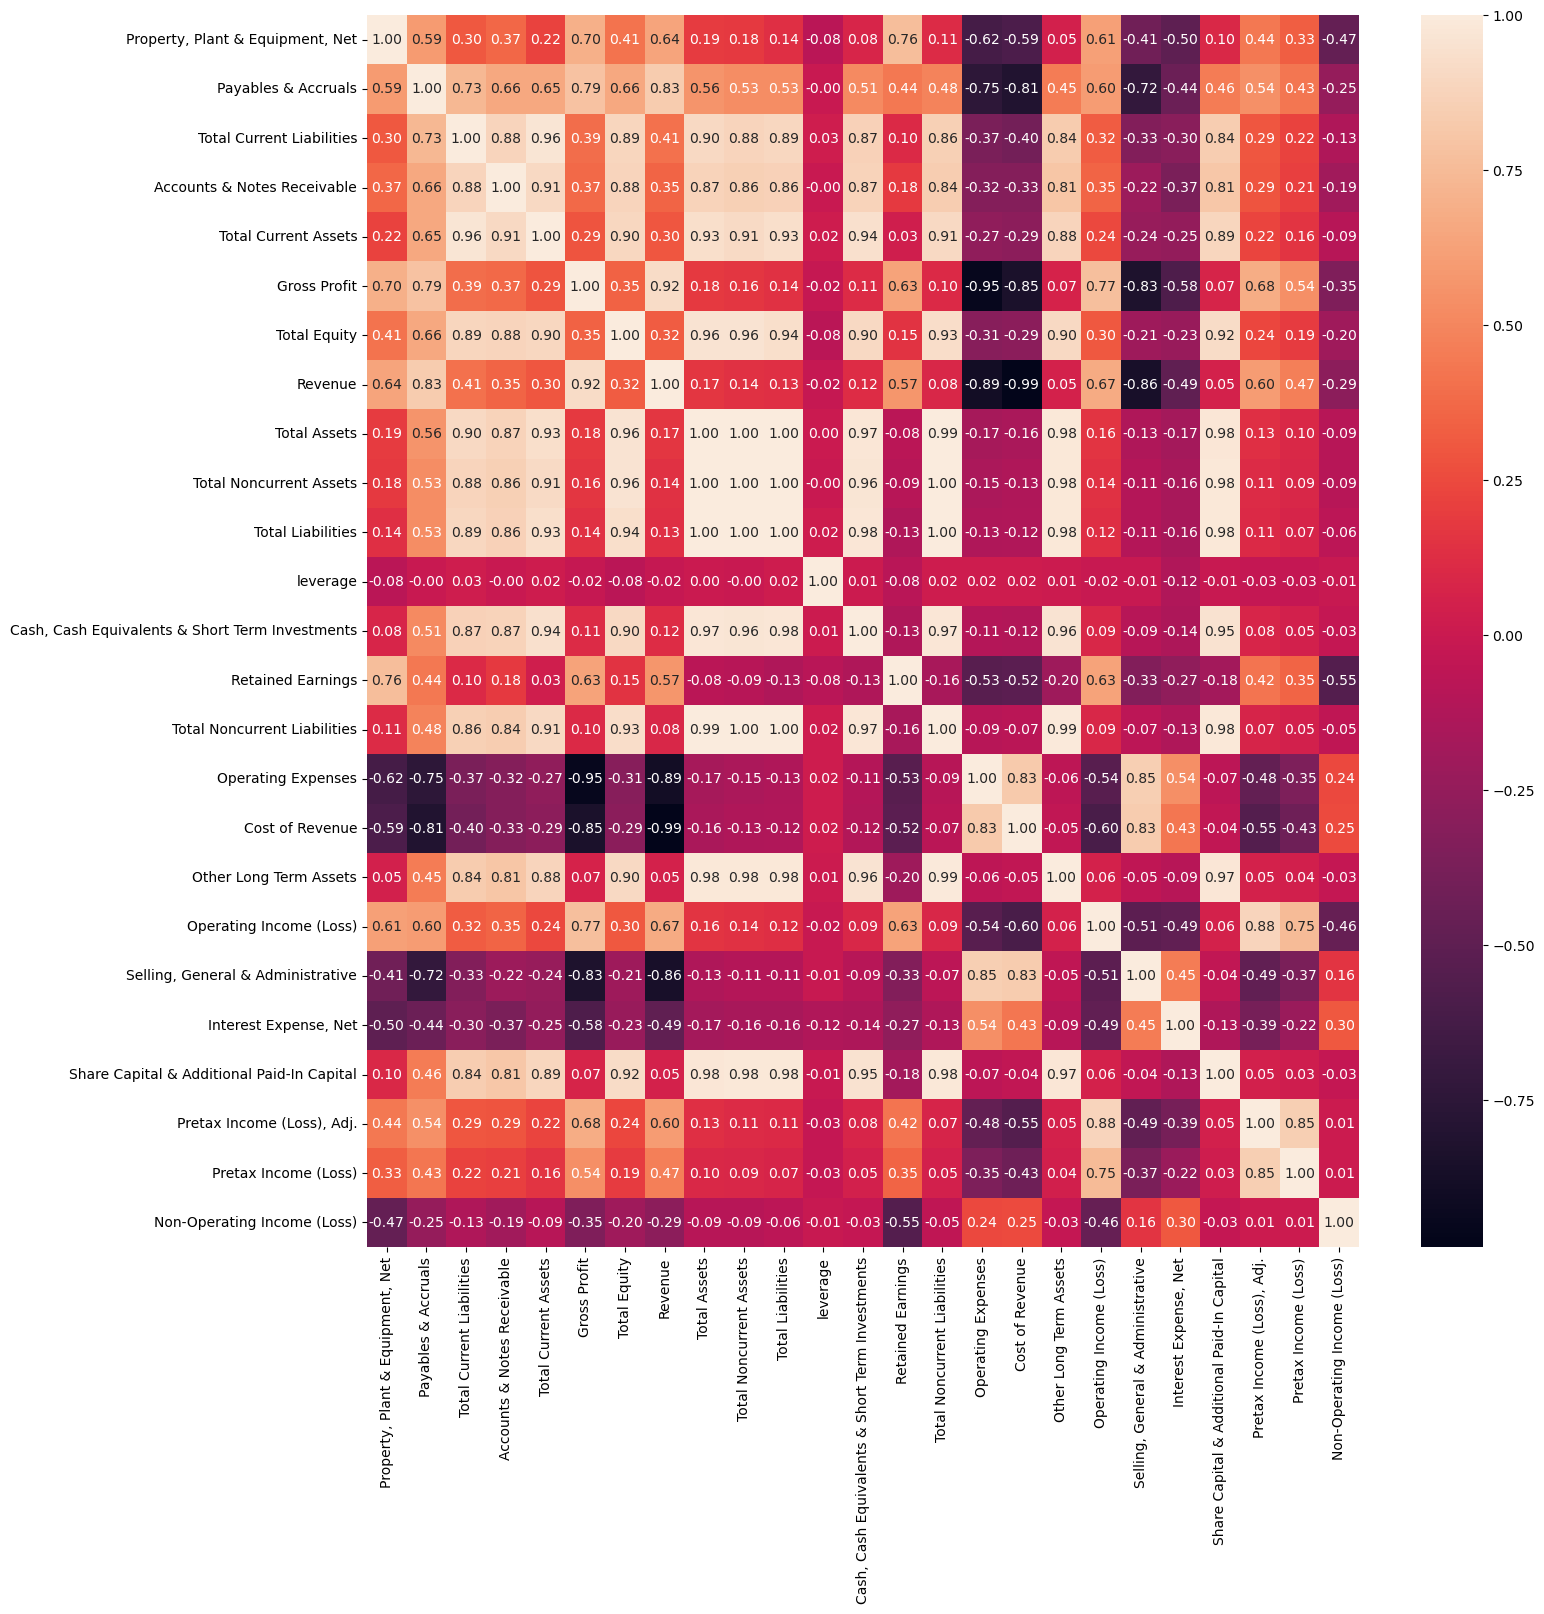

In [40]:
collist = corr_check(model,X_train_temp, 25)

In [41]:
print(collist)

['Property, Plant & Equipment, Net', 'Payables & Accruals', 'Total Current Liabilities', 'Accounts & Notes Receivable', 'Total Current Assets', 'Gross Profit', 'Total Equity', 'Revenue', 'Total Assets', 'Total Noncurrent Assets', 'Total Liabilities', 'leverage', 'Cash, Cash Equivalents & Short Term Investments', 'Retained Earnings', 'Total Noncurrent Liabilities', 'Operating Expenses', 'Cost of Revenue', 'Other Long Term Assets', 'Operating Income (Loss)', 'Selling, General & Administrative', 'Interest Expense, Net', 'Share Capital & Additional Paid-In Capital', 'Pretax Income (Loss), Adj.', 'Pretax Income (Loss)', 'Non-Operating Income (Loss)']


In [42]:
# We see a lot of multicollinearity here ,so we take out some columns
droplist = ['Revenue','Cost of Revenue','Accounts & Notes Receivable', 'Total Current Assets','Total Equity', 'Total Assets',
           'Total Noncurrent Assets','Operating Expenses', 'Total Liabilities','Pretax Income (Loss), Adj.', 'Cash, Cash Equivalents & Short Term Investments','Other Long Term Assets',
           'Share Capital & Additional Paid-In Capital','Pretax Income (Loss)', 'Income (Loss) from Continuing Operations', 'Net Income']

In [43]:
# We drop the columns
X_train_temp = X_train_temp.drop(droplist,axis = 1)
X_test_temp = X_test_temp.drop(droplist,axis = 1)

In [44]:
X_train_temp.shape

(6921, 18)

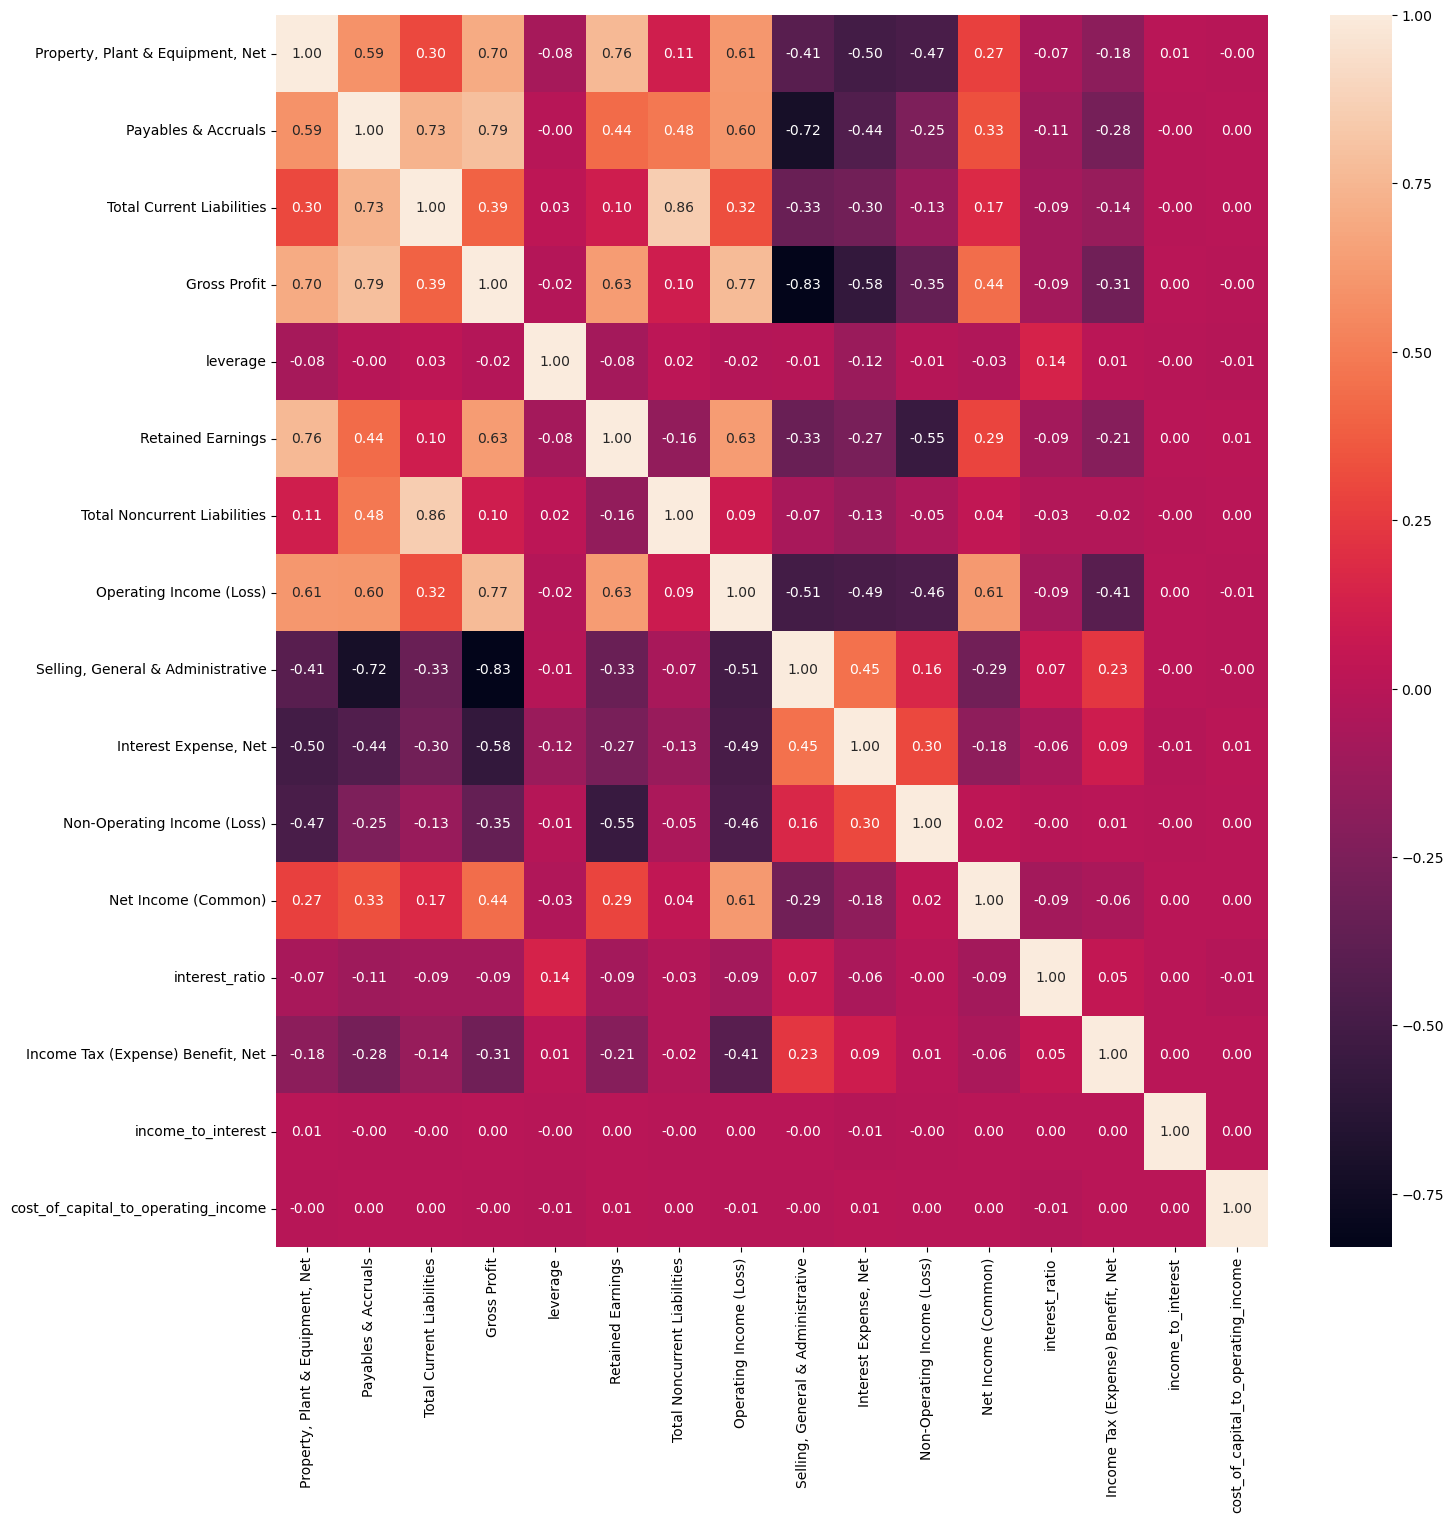

In [45]:
# We run it again
model = SelectKBest(chi2, k=16).fit(X_train_temp, y_train)
collist = corr_check(model,X_train_temp, 16)

In [46]:
# Looks like we got rid of most of the multicollinearity, we try out how the models perform with the new setup

In [47]:
# We put back our categrocial data
X_train_temp = pd.concat([X_train_temp, train_num_scaled], axis = 1)
X_test_temp = pd.concat([X_test_temp,test_num_scaled], axis = 1)

In [48]:
model_test(X_train_temp,X_test_temp,y_train,y_test)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 17   0   0   1  65   7   0   0   0]
 [  0   3   1   0  10   3   0   0   0]
 [  4   0   1   0   0   0   0   0   0]
 [  0   0   0 116 381   0   0   0   0]
 [  0   0   0  55 757  11   0   0   0]
 [  2   0   0   6 172  19   0   0   0]
 [  0   0   0   4   1   0   0   0   0]
 [  0   0   0  25  38   0   0   0   0]
 [  0   0   0  12  20   0   0   0   0]]
Logistic Regression score:  0.5274407856730213
Logistic Regression precision:  0.5056302377959413
Logistic Regression recall:  0.5274407856730213
Logistic Regression f1:  0.4482508668686979
[[ 62   0   0   4   8  16   0   0   0]
 [  5  12   0   0   0   0   0   0   0]
 [  4   0   1   0   0   0   0   0   0]
 [  0   0   0 375 111   4   0   7   0]
 [  4   0   0 124 673  21   0   1   0]
 [ 10   0   0   6  81 101   0   1   0]
 [  0   0   0   4   1   0   0   0   0]
 [  0   0   0  27   7   5   0  24   0]
 [  0   0   0  19   9   1   0   0   3]]
DecisionTree score:  0.7227036395147314
DecisionTree precision:  0.7261774240037631
DecisionTree recall:  

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 83   0   0   2   2   3   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  2   0   0 384  88   4   0  15   4]
 [  7   1   0  73 719  17   0   4   2]
 [  1   0   0   6  20 172   0   0   0]
 [  0   0   0   2   0   0   1   2   0]
 [  2   0   0  21   7   0   0  33   0]
 [  0   0   0  12  10   1   0   2   7]]
KNN score:  0.8209127671865973
KNN precision:  0.8168329377834878
KNN recall:  0.8209127671865973
KNN f1:  0.8166605045020326
[[ 55   0   0   5  21   9   0   0   0]
 [  9   0   0   0   0   8   0   0   0]
 [  2   0   0   0   0   3   0   0   0]
 [  0   0   0 340 157   0   0   0   0]
 [  1   0   0  90 721  11   0   0   0]
 [  5   0   0  14 116  64   0   0   0]
 [  0   0   0   5   0   0   0   0   0]
 [  0   0   0  46  16   1   0   0   0]
 [  0   0   0  24   8   0   0   0   0]]
RandomForest score:  0.681686886192952
RandomForest precision:  0.6325865416422113
RandomForest recall:  0.681686886192952
RandomForest f1:  0.644613859599064


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 88   0   0   1   0   1   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 468  27   0   0   2   0]
 [  0   0   0  15 807   1   0   0   0]
 [  1   0   0   0   6 192   0   0   0]
 [  0   0   0   2   0   0   2   1   0]
 [  0   0   0  11   3   1   0  48   0]
 [  0   0   0   8   3   0   1   0  20]]
ExtraTrees score:  0.951473136915078
ExtraTrees precision:  0.9515893118807639
ExtraTrees recall:  0.951473136915078
ExtraTrees f1:  0.9501740712775368
[[ 15   1   0   1  63  10   0   0   0]
 [  1  10   1   0   5   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   1 142 354   0   0   0   0]
 [  0   0   0  66 753   4   0   0   0]
 [  2   0   0   3 169  25   0   0   0]
 [  0   0   0   4   1   0   0   0   0]
 [  0   0   0  30  33   0   0   0   0]
 [  0   0   0  12  20   0   0   0   0]]
LinearSVC score:  0.5488157134604275
LinearSVC precision:  0.542127332073834
LinearSVC recall:  0.5488157134604275
LinearSVC f1:  0.478406279371

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 87   0   0   0   0   2   0   1   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 456  39   0   0   2   0]
 [  1   0   0  59 760   3   0   0   0]
 [  3   0   0   2  22 172   0   0   0]
 [  0   0   0   3   0   0   0   2   0]
 [  1   0   0  23   3   0   0  36   0]
 [  0   0   0  18   3   0   0   1  10]]
BaggingClassifier score:  0.8913922588099364
BaggingClassifier precision:  0.8935816864408784
BaggingClassifier recall:  0.8913922588099364
BaggingClassifier f1:  0.8868395932084774


D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
Our scores got a little worse, but we need way less data for our predictions, we will try to stiock with that.

In [49]:
X_train = X_train_temp
X_test = X_test_temp

## Hyperparameter search
Since eliminating multicollinearity did not change our result in a meaningful way before, we will now try to better the results with hyperparameter tuning for our best performing model.

In [50]:
# Random search
from sklearn.model_selection import RandomizedSearchCV

In [51]:
#  ExtraTrees classifier stands out with the best score, we will try to build on that
model = ExtraTreesClassifier()

In [52]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [53]:
parameters =  { 'n_estimators' : [100,300,500],
               'criterion': ['gini','entropy'],
               'max_features':['auto',None],
                'warm_start':[True,False],
                'class_weight':[None,'balanced'],
                'n_jobs' : [-1]
                }
              

In [54]:
random_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter=25, cv = 5, n_jobs = 10, scoring = "recall")

In [55]:
# Commented out, beacause it takes too long to rerun all the time

# random_search.fit(X_train,y_train)

# random_search.best_params_

In [56]:
# We try the model with the parameters
model = ExtraTreesClassifier( warm_start = False,
 n_jobs = -1,
 n_estimators = 300,
 max_features = 'auto',
 criterion = 'gini',
 class_weight = 'balanced')

In [57]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

[[ 88   0   0   1   0   1   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 465  30   0   1   1   0]
 [  0   0   0  19 803   1   0   0   0]
 [  1   0   0   0   6 192   0   0   0]
 [  0   0   0   2   0   0   2   1   0]
 [  0   0   0  12   7   0   0  44   0]
 [  0   0   0   9   3   0   1   0  19]]
 score:  0.9445407279029463
 precision:  0.945140326815277
 recall:  0.9445407279029463
 f1:  0.9429726855329237


In [58]:
# We tried to score for precision we try with the parameters delivered for that
model = ExtraTreesClassifier( warm_start = True,
 n_jobs = -1,
 n_estimators = 100,
 max_features = None,
 criterion = 'gini',
 class_weight= 'balanced')

In [59]:
model.fit(X_train, y_train)
# Predicting
predictions = model.predict(X_test)
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_test, y_test))
print(" precision: ",precision_score(y_test,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_test,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_test,predictions, average = 'weighted'))

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:765: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


[[ 88   0   0   1   0   1   0   0   0]
 [  0  17   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0]
 [  0   0   0 469  26   0   1   1   0]
 [  0   0   0  21 801   1   0   0   0]
 [  1   0   0   0   6 192   0   0   0]
 [  0   0   0   2   0   0   2   1   0]
 [  1   0   0  15   3   0   0  44   0]
 [  0   0   0   5   3   0   1   0  23]]
 score:  0.9480069324090121
 precision:  0.9484727412422981
 recall:  0.9480069324090121
 f1:  0.9469382424566871


## Plotting a confusion matrix for all data

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

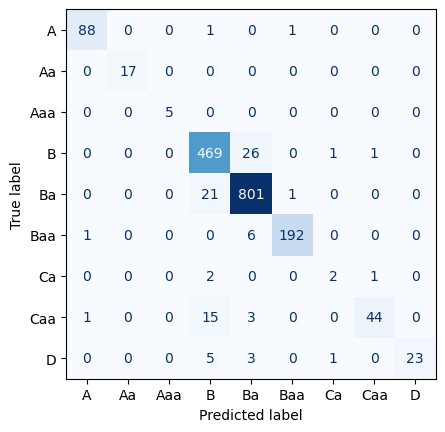

In [61]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', colorbar=False)

This is slightly better, we are keeping this as our final model.

## Fitting all data
Since we now have decided for a final model I will fit it again with all available data.

In [62]:
# Putting all data together
X_all = pd.concat([X_train,X_test],axis = 0)
y_all = pd.concat([y_train,y_test],axis = 0)

In [63]:
model = ExtraTreesClassifier( warm_start = False,
 n_jobs = -1,
 n_estimators = 100,
 max_features = None,
 criterion = 'gini',
 class_weight= 'balanced')

In [64]:
# Fitting the model
model.fit(X_all, y_all)

ExtraTreesClassifier(class_weight='balanced', max_features=None, n_jobs=-1)

In [65]:
# Just out of curiosiuty testing with training data

In [66]:
predictions = model.predict(X_all)
# Calculating confusion matrix
cm = confusion_matrix(y_all, predictions)
print(cm)
# Printing different evaluation metrics
print(" score: ", model.score(X_all, y_all))
print(" precision: ",precision_score(y_all,predictions, average = 'weighted'))
print(" recall: ",recall_score(y_all,predictions, average = 'weighted'))
print(" f1: ",f1_score(y_all,predictions, average = 'weighted'))

[[ 401    0    0    0    0    0    0    0    0    0]
 [   0   94    0    0    0    0    0    0    0    0]
 [   0    0   33    0    0    0    0    0    0    0]
 [   0    0    0 2633    0    0    0    0    0    0]
 [   0    0    0    0 4096    0    0    0    0    0]
 [   0    0    0    0    0  997    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0   10    0    0]
 [   0    0    0    0    0    0    0    0  285    0]
 [   0    0    0    0    0    0    0    0    0  102]]
 score:  1.0
 precision:  1.0
 recall:  1.0
 f1:  1.0


Looks quite overfit, since we just tested it on the data we trained it with, lets see how it performs on unseen data:

# Testing on unrated companies

We still have a lot of the dataset where we could not systematically get data for the companies.
I will run the model to predict some of the ratings and check them manually.

In [67]:
# Loading unused data
df_unrated = pd.read_csv('Prepared Frames/main_data.csv')

In [68]:
# We have not cleaned all this because we initially did not need to.
# Since we only can check a small number of samples,we drop all NaNs
df_unrated = df_unrated.dropna(axis = 0)
df_unrated.shape

(31204, 39)

## Selecting only relevant tickers

In [69]:
# We take just the part of the df where we do not have the tickers in our training and test data:
rated_tickers = list(main_df['Ticker'].unique())

In [70]:
# We exclude the already rated tickers
df_unrated = df_unrated[~df_unrated['Ticker'].isin(rated_tickers)]
df_unrated.shape

(21484, 39)

In [71]:
# Since we won't be able to get the historic rating data, we will just take the data for the latest year available "2021"
# So that when we check the ratings, they are as recent as possible
df_unrated = df_unrated[df_unrated['Fiscal Year'] ==2021]
df_unrated.shape

(4217, 39)

## Creating/Dropping the same columns

In [72]:
# First we create the columns as before
df_unrated = calc_fields(df_unrated)

In [73]:
df_unrated = df_unrated.dropna(axis = 0)
df_unrated.shape

(4216, 43)

In [74]:
# We extract the tickers for checking the results, beforehand we reset the indexes which are now not in order anymore
df_unrated.reset_index(inplace = True, drop = True)

In [75]:
unrated_tickers = df_unrated.Ticker

In [77]:
# This columns does not exist in the other data
drop_columns.remove('reduced_matches')

In [78]:
# We drop what we don't need
# First we have to take out a column that we created for finding matches, that now does not exist for our unmatched df

df_unrated = df_unrated.drop(drop_columns,axis = 1)

## Converting for predictions

In [79]:
# We preprocess the dataframe

# Num-Cat split
X_verify_num = df_unrated.select_dtypes('number')
X_verify_cat = df_unrated.select_dtypes('object')

In [80]:
# Bringing columns in the same order
X_verify_num = X_verify_num[X_train_num.columns]

In [81]:
X_verify_cat.columns

Index(['Industry'], dtype='object')

In [82]:
# Looks all right now

## Encoding/Scaling

In [83]:
# Encoding
X_verify_cat_encoded = pd.DataFrame(encoder.transform(X_verify_cat).toarray(),columns = column_name, index=X_verify_cat.index)

D:\Users\Giancarlo\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [84]:
# Scaling
X_verify_num_scaled = pd.DataFrame(transformer.transform(X_verify_num), columns = X_verify_num.columns, index = X_verify_num.index)

## Concatenating

In [85]:
X_verify = pd.concat([X_verify_cat_encoded,X_verify_num_scaled],axis = 1)

## Reducting Columns

In [86]:
# We reduce the columns according to our feature selection
X_verify = X_verify[X_all.columns]

## Predicting

In [87]:
predictions = model.predict(X_verify)

## Putting predictions on the unrated tickers

In [88]:
len(predictions)

4216

In [89]:
len(unrated_tickers)

4216

In [90]:
data = zip(unrated_tickers,predictions)

In [91]:
verification_df = pd.DataFrame(data, columns = ['Ticker','Pred_Rating'])
verification_df.head(3)

,Ticker,Pred_Rating
0,A,Ba
1,A,Ba
2,A,Ba


## Pulling out examples

In [96]:
# I have not set a random state for the first try and overwritten it by accident

In [97]:
# to_check = verification_df.sample(15)

In [98]:
# to_check.head(15)

In [99]:
# # Now I Look up the actual ratings for this:
# ratings_actual = [None,'Baa', None,'B',None,None,None,'Baa',None,'Ba',None,'Baa',None,None,'Baa']

In [100]:
# to_check['Act_Rating'] = ratings_actual
# to_check

Sources:
https://www.moodys.com/credit-ratings/Aon-plc-credit-rating-895000120?lang=en&cy=aus
https://www.moodys.com/research/Moodys-assigns-first-time-ratings-to-ARKO-Corp-including-a--PR_455784#:~:text=New%20York%2C%20October%2012%2C%202021,The%20outlook%20is%20stable.
https://www.moodys.com/research/Moodys-announces-completion-of-a-periodic-review-of-ratings-of--PR_431064?cy=can&lang=en
https://www.moodys.com/research/Moodys-upgrades-Horizon-Therapeutics-to-Ba1-stable-outlook--PR_464143
https://www.moodys.com/research/Moodys-Disclosures-on-Credit-Ratings-of-Mettler-Toledo-International-Inc--PR_239143

In [101]:
to_check2 = verification_df.sample(15, random_state=1337)
to_check2

,Ticker,Pred_Rating
3351,SHLS,Caa
3169,ROG,Ba
610,BRKS,B
1541,GMED,Ba
501,BGSF,B
2358,MODN,B
54,ACLS,B
3701,TGLS,B
1101,DRTT,B
634,CAG,Ba


In [102]:
# Now i Look up the actual ratings for this:
ratings_actual = [None,None,None,None,None,None,None,'Ba',None,'Baa',None,None,'Ba',None,None]
to_check2['Act_Rating'] = ratings_actual
to_check2

,Ticker,Pred_Rating,Act_Rating
3351,SHLS,Caa,None
3169,ROG,Ba,None
610,BRKS,B,None
1541,GMED,Ba,None
501,BGSF,B,None
2358,MODN,B,None
54,ACLS,B,None
3701,TGLS,B,Ba
1101,DRTT,B,None
634,CAG,Ba,Baa


https://www.moodys.com/research/Moodys-confirms-Tecnoglass-Ba3-rating-negative-outlook--PR_429442
https://www.moodys.com/research/Moodys-affirms-Conagra-Brands-Baa3-rating-revises-outlook-to-positive--PR_439418
https://www.moodys.com/research/Moodys-assigns-Ba3-ratings-to-B2Holding-ASA-outlook-stable--PR_382617